# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

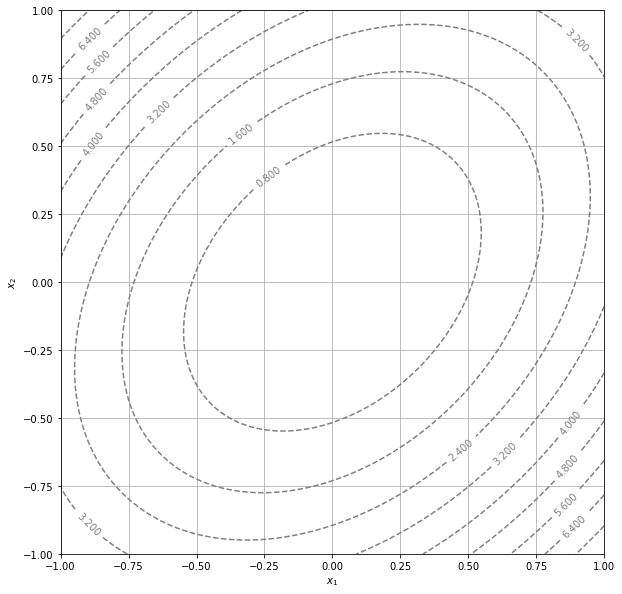

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

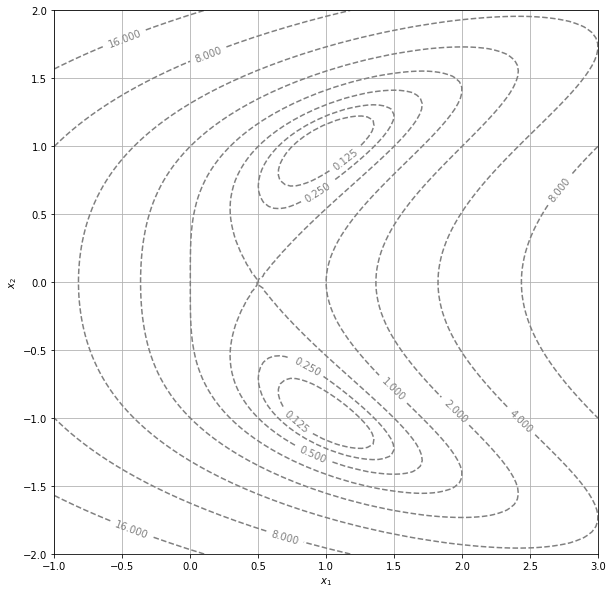

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

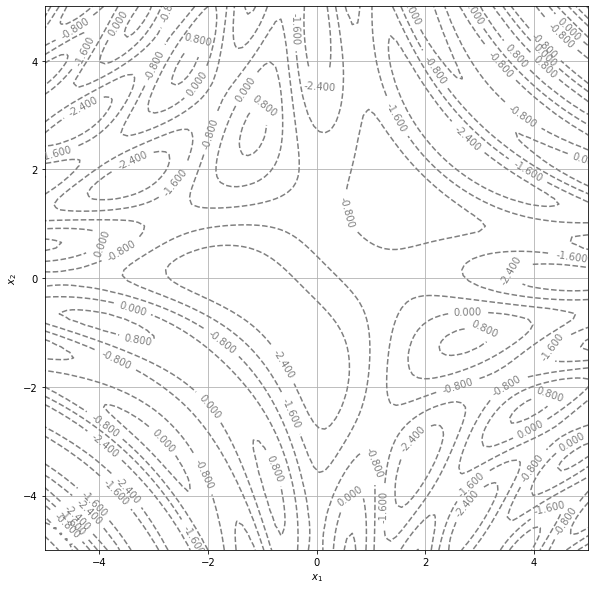

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

**Réponse**

L'ensemble de niveau $c$ est fermé et borné donc compact. \
En effet, il est fermé car c'est l'image réciproque d'un fermé par la fonction f qui est continue. \
Et il est borné car $ \exists$ r > 0 tel que $\forall \ (x_1, x_2) \in \mathbb{R}^2$, $\|(x_1,x_2)\| \geq \ r \Rightarrow \ f(x_1, x_2) \geq \ c + 1 $. Donc l'ensemble de niveau $c$ est inclus dans la boule ouverte de centre $(0,0)$ et de rayon $r$ dans l'espace normé $( \mathbb{R}^2 , \|.\| )$, donc il est bien borné. $\newline$

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

**Réponse**

$p(x_1, x_2)$ correspond à l'aire du parallélogramme formé par les vecteurs $(x - x_0)$ et $\frac{\nabla f(x_0)}{\|\nabla f(x_0)\|}$ comme déterminant de la matrice formée par ces 2 vecteurs.
$\newline $

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

**Réponse**

Soit $g: (x_1, x_2, \lambda) \in \mathbb{R}^3 \mapsto (f(x_1, x_2) - c, p(x_1, x_2) - \lambda) \in \mathbb{R}^2$.
- $f$ est continûment différentiable et p l'est aussi car p s'exprime polynomialement en fonction de $x_1$ et $x_2$. Donc g est aussi continûment différentiable.
- Soit $V$ un ouvert de $\mathbb{R}^2$ contenant $x_0$ et tel que $\nabla f$ ne s'annule pas sur $V$.
Alors, $\partial_x f$ ne s'annule pas sur $V$ car $\forall \ (x_1, x_2) \in \ V, \partial_x f (x_1, x_2) = (\nabla f(x_1, x_2), \nabla p(x_1, x_2)) \neq (0,0)$.
- De plus, $g(x_{10}, x_{20}, 0) = 0.$

D'après le théorème des fonctions implicites, il existe un voisinage ouvert $U \subset V$ de $x_0$ et un voisinage ouvert $W$ de $\lambda_0 = 0$ et une fonction implicite $\gamma : W \mapsto \mathbb{R}^2$, continûment différentiable, telle que pour tout $\lambda \in W$ et pour tout $x \in U$, $g(x, \lambda) = 0 \iff x = \gamma (\lambda)$.
On peut écrire que $W= \left]-\varepsilon, \varepsilon \right[$, avec $\varepsilon > 0$, quitte à prendre un ouvert de cette forme contenu dans $W$. \
On a donc $\forall \ x = (x_1, x_2) \in \ U, f(x_1, x_2) = 0 \iff (x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$. $\newline$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

**Réponse**

- Soit $B = p^{-1} \{ \left]-\varepsilon, \varepsilon \right[ \}$. $B$ est un ouvert de $\mathbb{R}^2$ car c'est l'image réciproque d'un ouvert par $p$ qui est continue.

On a $\forall \ (x_1, x_2) \in B$, $(x_1, x_2) = \gamma \circ (x_1, x_2)$ avec p et $\gamma$ continûment différentiables. Donc, en différenciant cette égalité, on obtient:

$\forall \ (x_1, x_2) \in B, \forall \ (h_1, h_2) \in \mathbb{R}^2$, 
$(h_1, h_2) = \gamma^{\prime}(t) \cdot (\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} h_1 - \frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} h_2) $, où $t = p(x_1, x_2)$.

Donc $\forall \ t \in \left]-\varepsilon, \varepsilon \right[$, $\gamma'(t) \neq 0$.

$\newline$
- $\forall \ t \in \left]-\varepsilon, \varepsilon \right[$, $f(\gamma(t)) = c$. Comme $f$ et $\gamma$ sont continûment différentiables, $f\circ \gamma$ est dérivable sur l'intervalle $\left]-\varepsilon, \varepsilon \right[$.

D'où, $\forall \ t \in \left]-\varepsilon, \varepsilon \right[$, $df_{\gamma(t)} \circ \ d\gamma_t (1) = 0$

C'est-à-dire, $\forall \ t \in \left]-\varepsilon, \varepsilon \right[$, $df_{\gamma(t)} (\gamma^{\prime}(t)) = 0$

Donc on a bien $\forall \ t \in \left]-\varepsilon, \varepsilon \right[$, $\left<\gamma^{\prime}(t), \nabla f (\gamma(t)) \right> = 0$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 10**-14

L'application à laquelle nous destinons cette fonction demande une précision relativement élevée pour éviter les chevauchements entre lignes de niveau. La précision sur les flottants est de $10 ^{-16}$, donc $10 ^{-14}$ suffira, d'autant plus que la convergence est très rapide avec la méthode de Newton.

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    L = np.array([x0, y0])
    for i in range(N):
        L -= (np.linalg.inv((J(F)(x0, y0)))).dot(F(x0, y0))
        x, y = L
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [16]:
def g(x,y):
    return np.array([f1(x,y)-.8,x-y])

Newton(g, 0.8, 0.8)

(0.4472135954999579, 0.4472135954999579)

(True, True)

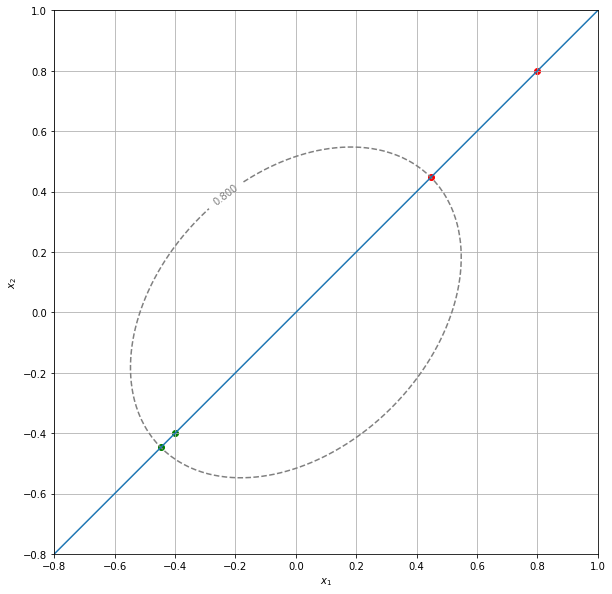

In [17]:
#on trace la ligne de niveau 0.8 de f1
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=[0.8])

#on règle les paramètres de la fenêtre et on trace la première bissectrice
plt.xlim(-0.8, 1)
plt.ylim(-0.8, 1)
plt.plot([-0.8, 1.],[-0.8, 1.])

#on affiche le point (0.8, 0.8) qui est notre point initial, ainsi que celles du point trouvé (en rouge)
x,y = Newton(g, 0.8, 0.8, N= 100)
plt.scatter([0.8, x],[0.8, y], color = 'r')

#on prend un autre point de départ (-0.4, -0.4), (en vert)
x1, x2 = Newton(g, -0.4, -0.4)
plt.scatter([-0.4, x1], [-0.4, x2], color = 'g')

#on prend encore un autre point de départ (.0, -0.3)
x01, x02 = Newton(g, .0, -0.3)
x01==x1, x02 ==x2 #le résultat est bien le même que l'appel à la fonction Newton précédent

In [18]:
#De même que précédemment on cherche les points sur la coube de niveau -2.40 de f3 à une distance 1.2 de 0
def k(x,y):
    return np.array([f3(x,y)+2.40,(x*x+y*y)**0.5-1.2])
Newton(k,0.,-2.)

(-1.0879445970028883, 0.5063364038386168)

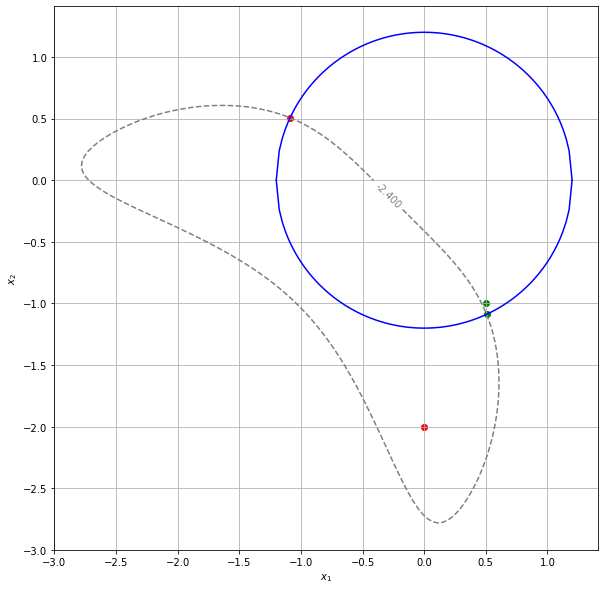

In [19]:
#on trace la ligne de niveau -2.40 de f3
display_contour(f3, x=np.linspace(-3., 1.0, 100), y=np.linspace(-3., 1.0, 100), levels=[-2.40])

#On trace le cercle de centre 0 et de rayon 1.2
X=np.linspace(-1.2,1.2,100)
Y=(1.2**2-X*X)**0.5
plt.plot(X,Y,'b')
plt.plot(X,-Y,'b')

#on affiche le point (0.,-2.) qui est notre point initial, ainsi que celles du point trouvé (en rouge)
x,y = Newton(k, 0., -2., N= 100)
plt.scatter([0., x],[-2., y], color = 'r')

#on prend un autre point de départ (0.5, -1), (en vert)
x,y = Newton(k, 0.5, -1., N= 100)
plt.scatter([0.5, x],[-1., y], color = 'g')


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

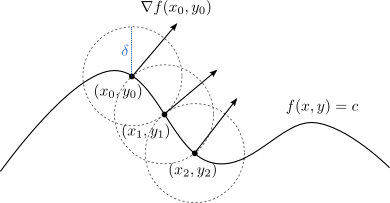

**Remarques sur la fonction level_curse**

On définit $T$, qui à un point de coordonnées (a,b) renvoie les coordonnées du vecteur de norme unitaire orthogonal à $\nabla f(x_0, y_0)$, qui est "à droite", à une distance delta, quand on est en (a,b) et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$. \
On part du point $(x_0, y_0)$: on récupère les coordonnées d'un point situé à sa droite quand on regarde le vecteur $\nabla f(x_0, y_0)$ grâce à la fonction T. On crée une fonction $H$ qui va de $\mathbb{R}^3$ dans $\mathbb{R}^2$ et qui vérifie: \
$H(x,y,delta) = 0 \iff$ ( $(x,y)$ est sur la même ligne de niveau que $(x_0, y_0)$ et $\|(x,y)-(x_0, y_0)\| = delta$ ). \
Puis on utilise la fonction Newton: comme on se place à proximité du point dont on cherche les coordonnées, l'appel à la fonction Newton doit bien renvoyer le résultat recherché. \
Puis on part du point atteint et on fait de même.

In [20]:
def level_curve(f, x0, y0, delta, N=100,eps=eps):
    c=f(x0,y0)
    def T(a,b):
        i,j=grad(f)(a,b)[1],-grad(f)(a,b)[0]
        t=np.sqrt(i*i+j*j)
        i=i*delta/t
        j=j*delta/t
        return a+i,b+j
    p1, p2 = x0, y0
    resultats= [[x0,y0]]
    for i in range (N):
        def H(X,Y):
            return np.array([(f(X,Y)-c),((p1-X)**2+(p2-Y)**2)**0.5-delta])
        X,Y=T(p1,p2)
        x,y=Newton(H,X,Y)
        resultats.append([x,y])
        p1, p2 = x,y
    return np.transpose(np.array(resultats))

(-1.1, 1.1)

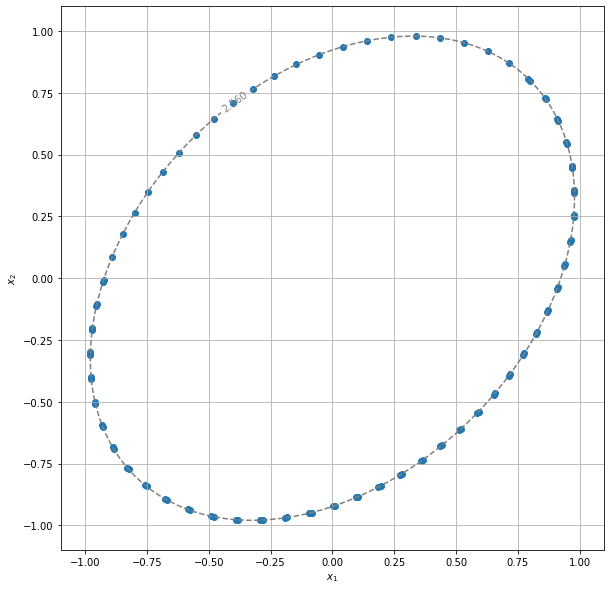

In [21]:
#on commence par tracer la ligne de niveau de f1 à laquelle le point (0.8, 0.8) appartient
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=[f1(0.8,0.8)])

#on calcule les coordonnées de 100 points de cette courbe et on les trace
#placer 100 points permet de bien voir l'adéquation entre la ligne de niveau tracé à l'aide de display_contour
#et l'ensemble des points trouvés à l'aide de level_curve
L1=level_curve(f1,0.8,0.8,0.1)
plt.scatter(L1[0], L1[1])

#on ajuste la fenêtre pour plus de clarté
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.7, 1.7)

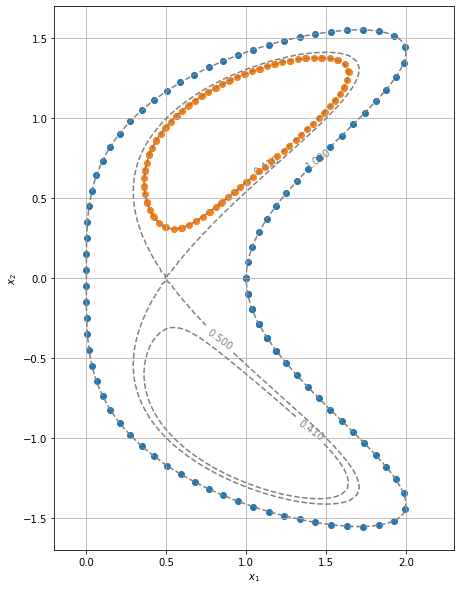

In [22]:
#autre exemple: avec la fonction f2, et avec deux courbes de niveau
display_contour(f2, x=np.linspace(-.5, 2.5, 100), y=np.linspace(-2., 2.0, 100), levels=[f2(1., .6), .5, 1.])

L2= level_curve(f2,1.,.0,0.1)
plt.scatter(L2[0], L2[1])

L22= level_curve(f2,1.,.6,0.1)
plt.scatter(L22[0], L22[1])

#L23= level_curve(f3, 0.5, -1., .1)
#plt.scatter(L23[0], L23[1])

plt.xlim(-0.2, 2.3)
plt.ylim(-1.7, 1.7)

(-0.5, 3.3)

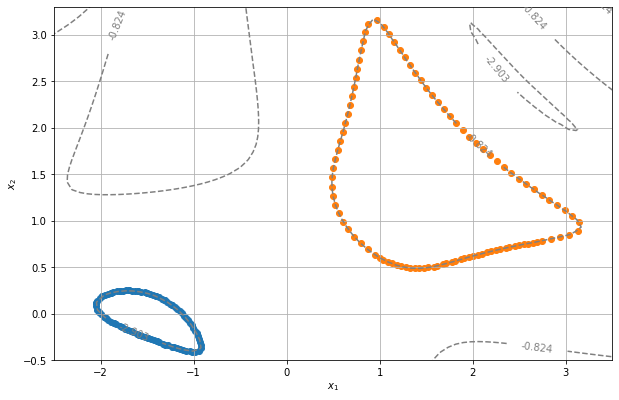

In [23]:
#autre exemple avec f3
display_contour(f3, x=np.linspace(-4., 4., 100), y=np.linspace(-4., 4., 100), levels=[f3(-1.4, -.3), f3(1., .6)])

L3= level_curve(f3,-1.4,-.3,0.1)
plt.scatter(L3[0], L3[1])
L32= level_curve(f3,1.,.6,0.1)
plt.scatter(L32[0], L32[1])

plt.xlim(-2.5, 3.5)
plt.ylim(-.5, 3.3)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

Les courbes "auto-intersectanctes" sont très rares. En effet, elles correspondent à un point col, telles la courbe de niveau 0.5 de f2.

La fonction se_croiser prend en argument les coordonnées de quatre points A, B, C et D sous la forme de quatre tableaux et renvoie vrai si et seulement si les segments $\left[AB \right]$ et $\left[CD \right]$ se croisent.

In [24]:
def se_croiser(A,B,C,D):
    xa,xb,xc,xd,ya,yb,yc,yd=A[0],B[0],C[0],D[0],A[1],B[1],C[1],D[1]
    if not (xd-xc)*(yb-ya)-(xb-xa)*(yd-yc):
        return 0 #si (AB) et (CD) sont parallèles
    Ucd=((xb-xa)*(yc-ya)-(xc-xa)*(yb-ya))/((xd-xc)*(yb-ya)-(xb-xa)*(yd-yc))
    Uab=((xd-xc)*(yc-ya)-(xc-xa)*(yd-yc))/((xd-xc)*(yb-ya)-(xb-xa)*(yd-yc))
    # les coordonnées du point d'intersection P sont telles que:
    # P=A+Uab(B-A) et P=C+Ucd(D-C)
    if 0 <= Ucd<=1 and 0 <= Uab <=1:
        return 1 #si le point d'intersection des deux droites appartient aux deux segments
    return 0

La fonction level_curve2 fonctionne de la même manière que level_curve mais au lieu d'une boucle for, nous allons utiliser une boucle while, et ainsi arrêter la fonction avant les segments produits ne se croisent. \
La première boucle for sert à tracer les premiers points pour que l'on puisse vérifier
Le booléen croisement sert à arrêter la fonction dès que l'on a trouvé un point tels que le dernier segment ainsi produit intersecte la premier segement. \
La condition N $<$500 dans la boucle while a pour unique but que l'exécution de la fonction level_curve2 ne prenne pas trop de temps.

In [25]:
 def level_curve2(f, x0, y0, delta,eps=eps):
    c=f(x0,y0)
    N=0
    def T(a,b):
        i,j=grad(f)(a,b)[1],-grad(f)(a,b)[0]
        t=np.sqrt(i*i+j*j)
        i=i*delta/t
        j=j*delta/t
        return a+i,b+j
    p1, p2 = x0, y0
    resultats= [[x0,y0]]
    for i in range (4):
        def H(X,Y):
            return np.array([(f(X,Y)-c),((p1-X)**2+(p2-Y)**2)**0.5-delta])
        X,Y=T(p1,p2)
        x,y=Newton(H,X,Y)
        resultats.append([x,y])
        p1, p2 = x,y
        croisement=se_croiser(resultats[-1],resultats[-2],resultats[0],resultats[1])
    while not croisement and N<500:
        def H(X,Y):
            return np.array([(f(X,Y)-c),((p1-X)**2+(p2-Y)**2)**0.5-delta])
        X,Y=T(p1,p2)
        x,y=Newton(H,X,Y)
        if se_croiser([x,y],resultats[-2],resultats[0],resultats[1]):
            croisement = True
        else:
            resultats.append([x,y])
        p1, p2 = x,y
        N+=1
    return np.transpose(np.array(resultats))

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

(-1.1, 1.1)

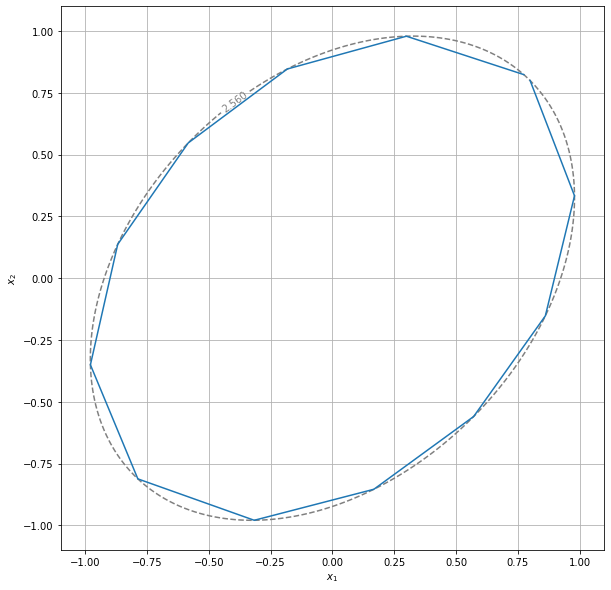

In [26]:
#on commence par tracer la ligne de niveau de f1 à laquelle le point (0.8, 0.8) appartient
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=[f1(0.8,0.8)])

L1=level_curve2(f1,0.8,0.8, 0.5) #on prend un 'grand' delta et on trace les segments entre les points
#pour vérifier que la fonction a bien fait ce que l'on attendait
plt.plot(L1[0], L1[1])

#on ajuste la fenêtre pour plus de clarté
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

#on voit bien que la fonction a calculé les points de la courbe et s'est arrêtée juste avant de croiser un segment déjà tracé.

(-1.7, 1.7)

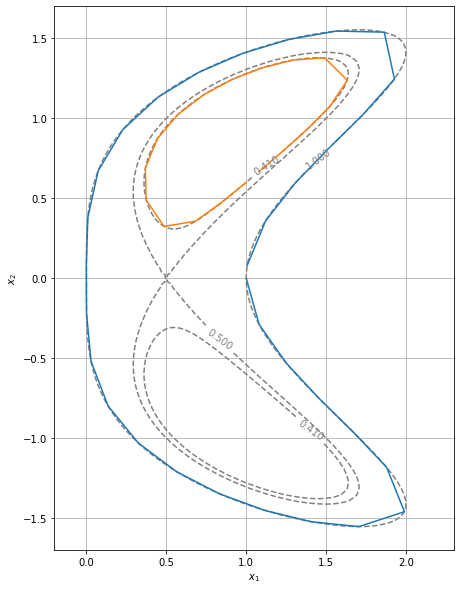

In [27]:
#exemple avec la fonction f2
display_contour(f2, x=np.linspace(-.5, 2.5, 100), y=np.linspace(-2., 2.0, 100), levels=[f2(1., .6), .5, 1.])

L2= level_curve2(f2,1.,.0,0.3)
plt.plot(L2[0], L2[1])

L22= level_curve2(f2,1.,.6,0.2)
plt.plot(L22[0], L22[1])

plt.xlim(-0.2, 2.3)
plt.ylim(-1.7, 1.7)

#dans les deux cas, on voit bien les arrêts de la fonction au niveau des points initiaux

(-0.5, 3.3)

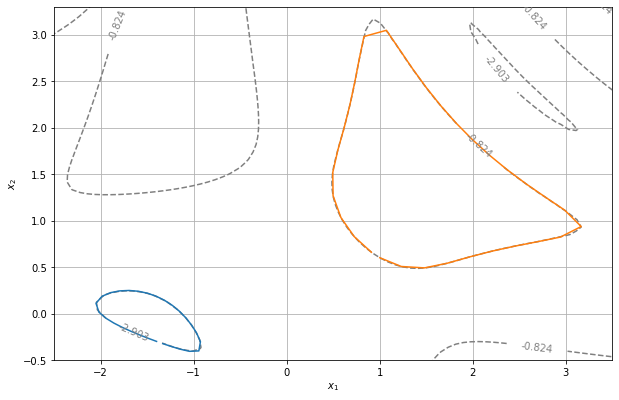

In [28]:
#autre exemple avec f3
display_contour(f3, x=np.linspace(-4., 4., 100), y=np.linspace(-4., 4., 100), levels=[f3(-1.4, -.3), f3(1., .6)])

L3= level_curve2(f3,-1.4,-.3,0.1)
plt.plot(L3[0], L3[1])

L32= level_curve2(f3,1.,.6,0.25)
plt.plot(L32[0], L32[1])

plt.xlim(-2.5, 3.5)
plt.ylim(-.5, 3.3)

#dans les deux cas, on voit bien les arrêts de la fonction au niveau des points initiaux

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

**Réponse**

On déduit des conditions sur la fonction $\gamma$ les égalités suivantes:

$P_1 = \begin{pmatrix}
a\\ d \end{pmatrix} $ \
$P_2 = \begin{pmatrix}
a+b+c \\ d+e+f \end{pmatrix}$

Donc $P_2 -P_1 = \begin{pmatrix}
b+c \\ e+f \end{pmatrix}$ \
De plus, on cherche $\lambda$ et $\mu \in \mathbb{R}^{+*}$ tels que \
$\lambda \cdot u_1 = \begin{pmatrix} b \\ e \end{pmatrix}$ \
et $\mu \cdot u_2 = \begin{pmatrix} 2 \cdot c + b \\ 2 \cdot f + e \end{pmatrix}$

D'où $\lambda \cdot u_1 + \mu \cdot u_2 = 2 \cdot (P_2 - P_1)$

Deux cas se présentent à nous:

- 1er cas: si $u_1$ et $u_2$ sont libres.

Soit $V$ orthogonal à $u_1$. Soit $W$ orthogonal à $u_2$.

Alors $\mu = \frac{2 \cdot \left< P_2 - P_1, V \right>}{\left< u_2,V \right>} > 0$

et $\lambda = \frac{2 \cdot \left< P_2 - P_1, W \right>}{\left< u_1,W \right>} > 0$

Dans le cas où $\mu$ et $\lambda$ sont positifs, on trouve facilement les expressions de b, c, e et f.

- 2e cas: si $u_1$ et $u_2$ sont liés:
alors ils sont tous deux colinéaires à $P_2 - P_1$.

**Remarque**

Dans le cas où $u_1$ et $u_2$ sont liés, il est plus complexe de trouver des solutions car lorsqu'elles existent, elles ne sont pas uniques. or, ce sont des cas très rares (surtout numériquement où avoir deux vecteurs colinéaires est très peu probable). Nous avons donc fait le choix de traiter ce cas par des segments de droites.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [29]:
def gamma(t,P1,P2,u1,u2):
    T=np.array([u1[1],-u1[0]]) #T est un vecteur orthogonal à u1
    if u2.dot(T)==0:   #si u1 et u2 colinéaires
        X=P1[0]*np.ones(len(t))+(P2-P1)[0]*t
        Y=P1[1]*np.ones(len(t))+(P2-P1)[1]*t
        return np.array([X,Y])
    mu=2*(P2-P1).dot(T)/(u2.dot(T))
    if mu<0:
        X=P1[0]*np.ones(len(t))+(P2-P1)[0]*t
        Y=P1[1]*np.ones(len(t))+(P2-P1)[1]*t
        return np.array([X,Y])
    H=np.array([u2[1],-u2[0]]) #H est un vecteur orthogonal à u2
    l=2*(P2-P1).dot(H)/(u1.dot(H))
    if l<0:
        X=P1[0]*np.ones(len(t))+(P2-P1)[0]*t
        Y=P1[1]*np.ones(len(t))+(P2-P1)[1]*t
        return np.array([X,Y])
    b,e=l*u1[0],l*u1[1]
    c,f=(mu*u2-(P2-P1))[0],(mu*u2-(P2-P1))[1]
    a,d = P1[0], P1[1]
    X=a*np.ones(len(t))+b*t+c*t*t
    Y=d*np.ones(len(t))+e*t+f*t*t
    return (np.array([X,Y]))

**Remarque**

Pour les cas où $u_1$ et $u_2$ sont colinéaires, et dans les cas où $\mu$ ou $\lambda$ sont négatifs, $\gamma$ est une droite qui relie $P_1$ et $P_2$.

<ipython-input-50-f57d1d90930c>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


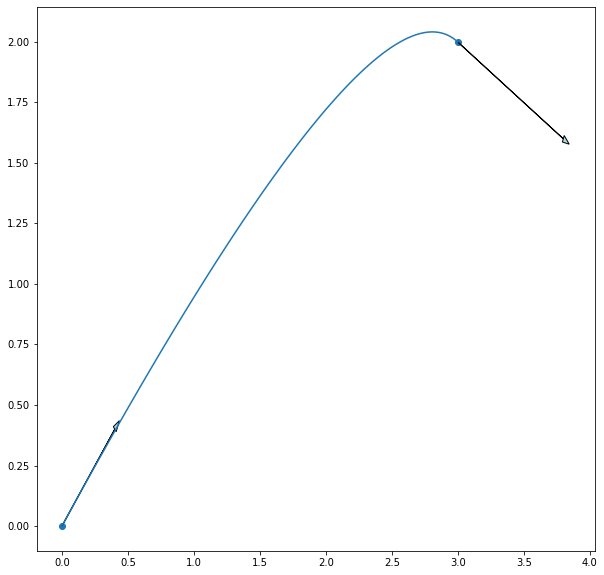

In [50]:
P1=np.array([0.,0.])
P2=np.array([3.,2.])
u1=np.array([1.,1.])
u2=np.array([4.,-2])
t=np.linspace(0,1,100)
L = gamma(t, P1, P2, u1, u2)
plt.plot(L[0], L[1])
plt.scatter([P1[0], P2[0]], [P1[1], P2[1]])
ax=plt.axes()
ax.arrow(P1[0], P1[1], u1[0]/2.5, u1[1]/2.5, head_width=0.03, head_length=0.05, fc='lightblue', ec='black')
ax.arrow(P2[0], P2[1], u2[0]/5, u2[1]/5, head_width=0.03, head_length=0.05, fc='lightblue', ec='black');

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [31]:
def level_curve3(f, x0,y0,delta,O):
    L=level_curve2(f, x0, y0, delta).T
    if O==1:
        return L.T
    resultat=[]
    t=np.linspace(0,1,O+1)
    A=len(L)
    for i in range (A):
        P1=L[i]
        P2=L[(i+1)%A]
        u1=L[(i+1)%A]-L[(i-1)%A]
        u2=L[(i+2)%A]-L[i%A]
        K=gamma(t,P1,P2,u1,u2).T
        for j in range (len(t)):
            resultat.append(K[j])
    return np.array(resultat).T

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

(-1.1, 1.1)

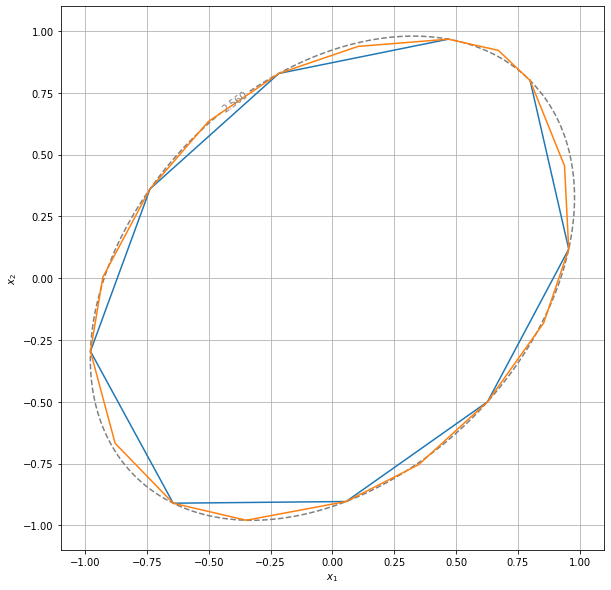

In [32]:
#on commence par tracer la ligne de niveau de f1 à laquelle le point (0.8, 0.8) appartient
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=[f1(0.8,0.8)])


L1=level_curve3(f1,0.8,0.8,0.7,1)
plt.plot(L1[0], L1[1])
L2=level_curve3(f1,0.8,0.8,0.7,2)
plt.plot(L2[0], L2[1])
#L1 en bleu correspond à levelcurve 2 avec un oversampling de 1
#En rouge L2 a pour effet avec un oversampling de 2 de rajouter un point entre chaque couple de points consécutifs de L1

#on ajuste la fenêtre pour plus de clarté
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

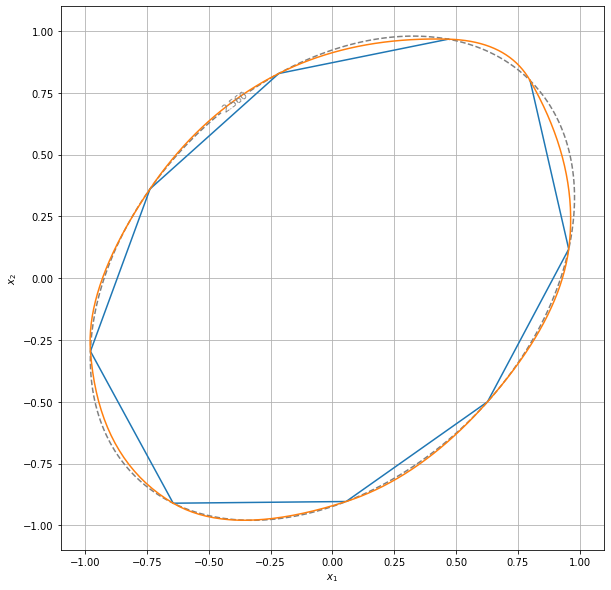

In [33]:
#on commence par tracer la ligne de niveau de f1 à laquelle le point (0.8, 0.8) appartient
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=[f1(0.8,0.8)])
L1=level_curve3(f1,0.8,0.8,0.7,1)
plt.plot(L1[0], L1[1])
L2=level_curve3(f1,0.8,0.8,0.7,20)
plt.plot(L2[0], L2[1])
#cette fois-ci on utilise vraiment le potentiel de l'oversampling en le règlant à 20. On peut voir 
#qu'il colle relativement bien aux courbes de niveau

#on ajuste la fenêtre pour plus de clarté
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

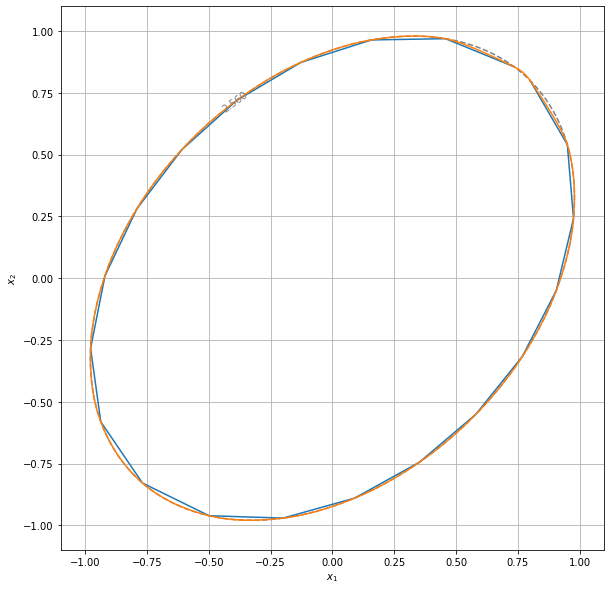

In [34]:
#on commence par tracer la ligne de niveau de f1 à laquelle le point (0.8, 0.8) appartient
display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=[f1(0.8,0.8)])
L1=level_curve3(f1,0.8,0.8,0.3,1)
plt.plot(L1[0], L1[1])
L2=level_curve3(f1,0.8,0.8,0.3,20)
plt.plot(L2[0], L2[1])
#La meilleure approche est une combinaison d'un delta moyen (ici 0.3) et de l'oversampling 
#pour rester fidèle à la courbe de niveau sans trop de calculs

#on ajuste la fenêtre pour plus de clarté
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

(-1.7, 1.7)

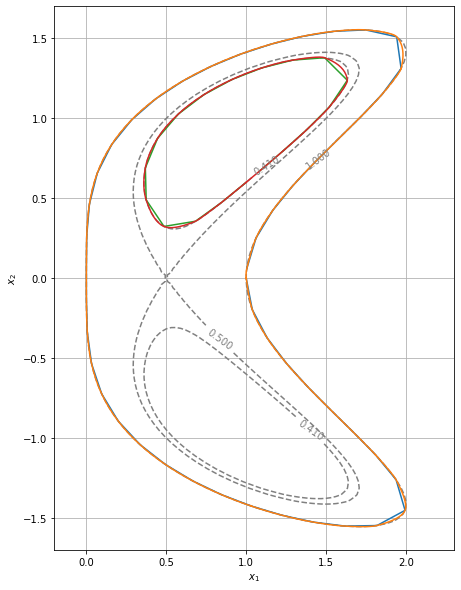

In [35]:
#exemple avec la fonction f2
display_contour(f2, x=np.linspace(-.5, 2.5, 100), y=np.linspace(-2., 2.0, 100), levels=[f2(1., .6), .5, 1.])

L2= level_curve3(f2,1.,.0,0.2,1)
plt.plot(L2[0], L2[1])
L3= level_curve3(f2,1.,.0,0.2,20)
plt.plot(L3[0], L3[1])

L22= level_curve3(f2,1.,.6,0.2,1)
plt.plot(L22[0], L22[1])
L33= level_curve3(f2,1.,.6,0.2,20)
plt.plot(L33[0], L33[1])

plt.xlim(-0.2, 2.3)
plt.ylim(-1.7, 1.7)